In [1]:
#imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import gdown
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import preprocessing
import visualizations
from getfile import getfile
if not os.path.isfile('sbcdata.csv'):
    getfile()


In [2]:
#processing
file_path = r'sbcdata.csv'
df = pd.read_csv(file_path)

# to save the outputted dataframes set save_csv to true
df_uml, df_umg = preprocessing.preprocess(df, save_csv=False)

Count of each target variable before preprop: Diagnosis
0.0    1776380
1.0     251395
Name: count, dtype: int64
Count of each target variable after dropping na and duplicates: Diagnosis
0.0    1673822
1.0     243123
Name: count, dtype: int64
Count of each target variable after outlier removal: Diagnosis
0.0    1521216
1.0     184955
Name: count, dtype: int64
Length of X_df after scaling: 1706171
Count of each target variable after rescaling: Diagnosis
0.0    1521216
1.0     184955
Name: count, dtype: int64
Count of each target variable before undersampling: Diagnosis
0.0    1521216
1.0     184955
Name: count, dtype: int64
Count of each target variable after undersampling: Diagnosis
0.0    184955
1.0    184955
Name: count, dtype: int64
Count of each target variable before preprop: Diagnosis
0.0    526943
1.0    128578
Name: count, dtype: int64
Count of each target variable after dropping na and duplicates: Diagnosis
0.0    513133
1.0    122511
Name: count, dtype: int64
Count of each tar

In [3]:
#MODEL TRAINING AND EVALUATION FUNCTION

def train_eval_model(model, df_val, df_train):
    #split data for model
    X = df_train.drop(columns=['Diagnosis'])
    y = df_train['Diagnosis']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #evaluate test set of training data
    metrics_train = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average="weighted"),
    "recall": recall_score(y_test, y_pred, average="weighted"),
    "f1_score": f1_score(y_test, y_pred, average="weighted"),
    "confusion_matrix": confusion_matrix(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], multi_class="ovr", average="weighted"),
    "model" : model
    }

    #prep val data for evaluation
    X_val = df_val.drop(columns=['Diagnosis'])
    y_val = df_val['Diagnosis']
    y_val_pred = model.predict(X_val)

    #evaluate validation data
    metrics_val = {
    "accuracy": accuracy_score(y_val, y_val_pred),
    "precision": precision_score(y_val, y_val_pred, average="weighted"),
    "recall": recall_score(y_val, y_val_pred, average="weighted"),
    "f1_score": f1_score(y_val, y_val_pred, average="weighted"),
    "confusion_matrix": confusion_matrix(y_val, y_val_pred),
    "roc_auc": roc_auc_score(y_val, model.predict_proba(X_val)[:, 1], multi_class="ovr", average="weighted"),
    "model" : model
    
    }

    return metrics_train, metrics_val

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'distance'}


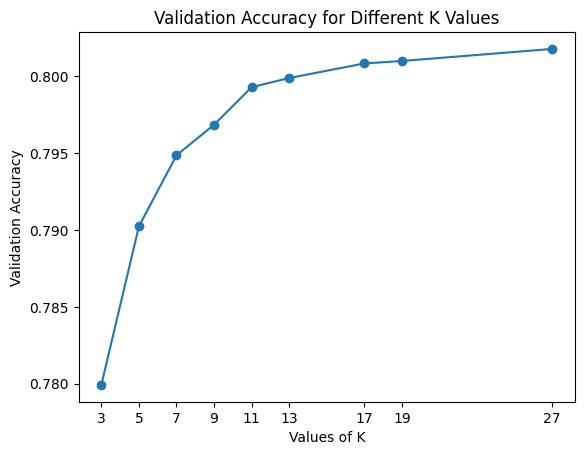

Training Metrics:
Accuracy:     0.8053
Recall:       0.8053
F1 Score:     0.8049
ROC AUC:      0.8842
Validation Metrics:
Accuracy:     0.7099
Recall:       0.7099
F1 Score:     0.7095
ROC AUC:      0.7784


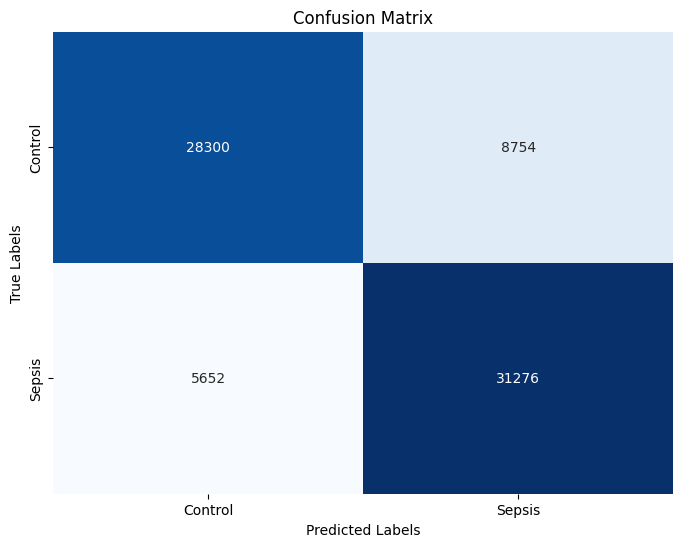

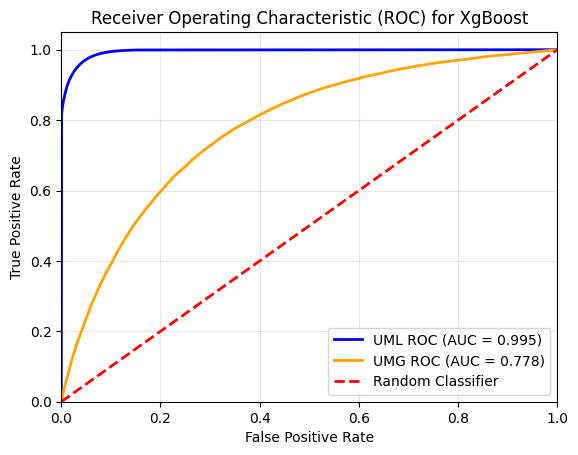

In [ ]:
#KNN EVALUATION
"""
NOTE: on our final run of this code we got a different result and are unsure why
we apologize for the discrepancy in the report and this code block
"""

#prep data for grid search of knn

X = df_uml.drop(columns=['Diagnosis'])
y = df_uml['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#KNN grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 17, 19, 27],
    'weights': ['distance'],
    'metric': ['manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


#Plot for accuracy of each K value
k_range = [3, 5, 7, 9, 11, 13, 17, 19, 27]
accuracy_scores = []

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

plt.plot(k_range, accuracy_scores, marker='o')
plt.title('Validation Accuracy for Different K Values')
plt.xlabel('Values of K')
plt.ylabel('Validation Accuracy')
plt.xticks(k_range)
plt.show()


#Get model metrics in the same format as other models
metrics_train, metrics_val = train_eval_model(model=best_knn, df_train=df_uml, df_val=df_umg)

print("Training Metrics:")
print(f"Accuracy:     {metrics_train['accuracy']:.4f}")
print(f"Recall:       {metrics_train['recall']:.4f}")
print(f"F1 Score:     {metrics_train['f1_score']:.4f}")
print(f"ROC AUC:      {metrics_train['roc_auc']:.4f}")

print("Validation Metrics:")
print(f"Accuracy:     {metrics_val['accuracy']:.4f}")
print(f"Recall:       {metrics_val['recall']:.4f}")
print(f"F1 Score:     {metrics_val['f1_score']:.4f}")
print(f"ROC AUC:      {metrics_val['roc_auc']:.4f}")

visualizations.plot_confusion_matrix(metrics_train)
visualizations.plot_roc_curves(df1=df_uml, df2=df_umg, model_metrics=metrics_train)


Training Metrics:
Accuracy:     0.8097
Recall:       0.8097
F1 Score:     0.8094
ROC AUC:      0.8899
Validation Metrics:
Accuracy:     0.7111
Recall:       0.7111
F1 Score:     0.7105
ROC AUC:      0.7826


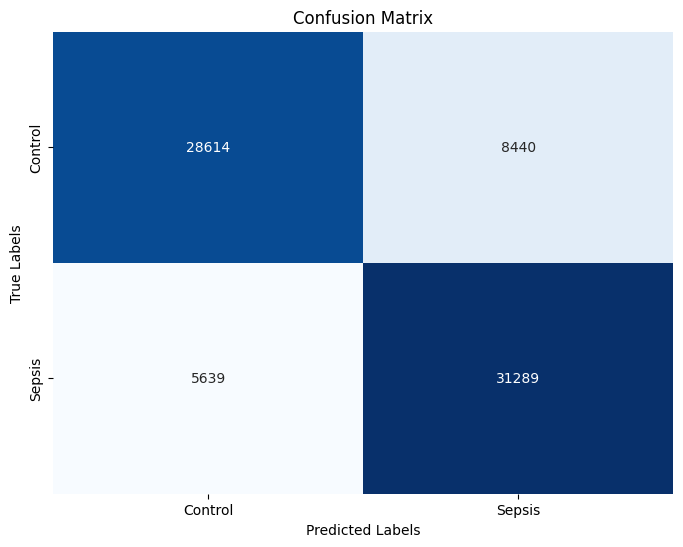

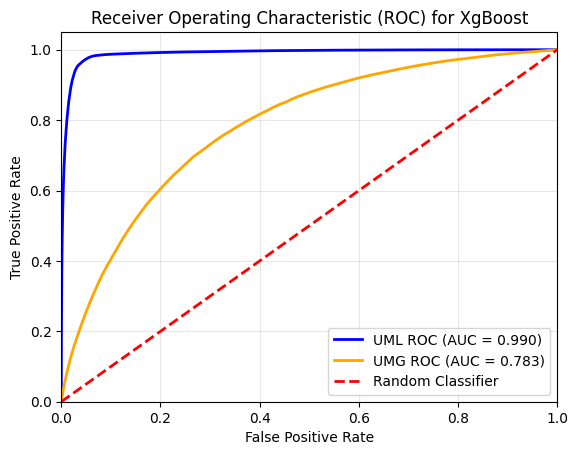

ValueError: tree must be Booster, XGBModel or dict instance

In [7]:
#RANDOM FOREST CLASSIFIER

#Hyperparamenter tunning
#param_grid = {'n_estimators': [100, 200, 250, 300], 
#              'max_features': ['sqrt', 'log2', None], 
#              'max_depth': [3, 6, 9, 20, None], 
#              'min_samples_split': [2,10,15]
#} 
#grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid) 
#grid_search.fit(X_train, y_train) 
#print(grid_search.best_estimator_) 


#model evaluation for random forest 

rf_model = RandomForestClassifier(n_estimators = 200,
                                  random_state = 42, 
                                  n_jobs = -1,
                                  class_weight='balanced'
)

metrics_train, metrics_val = train_eval_model(model=rf_model, df_train=df_uml, df_val=df_umg)

print("Training Metrics:")
print(f"Accuracy:     {metrics_train['accuracy']:.4f}")
print(f"Recall:       {metrics_train['recall']:.4f}")
print(f"F1 Score:     {metrics_train['f1_score']:.4f}")
print(f"ROC AUC:      {metrics_train['roc_auc']:.4f}")

print("Validation Metrics:")
print(f"Accuracy:     {metrics_val['accuracy']:.4f}")
print(f"Recall:       {metrics_val['recall']:.4f}")
print(f"F1 Score:     {metrics_val['f1_score']:.4f}")
print(f"ROC AUC:      {metrics_val['roc_auc']:.4f}")

visualizations.plot_confusion_matrix(metrics_train)
visualizations.plot_roc_curves(df1=df_uml, df2=df_umg, model_metrics=metrics_train)
visualizations.plot_feature_importance(metrics_train)

Training Metrics:
Accuracy:     0.8066
Recall:       0.8066
F1 Score:     0.8063
ROC AUC:      0.8876
Validation Metrics:
Accuracy:     0.7165
Recall:       0.7165
F1 Score:     0.7162
ROC AUC:      0.7890


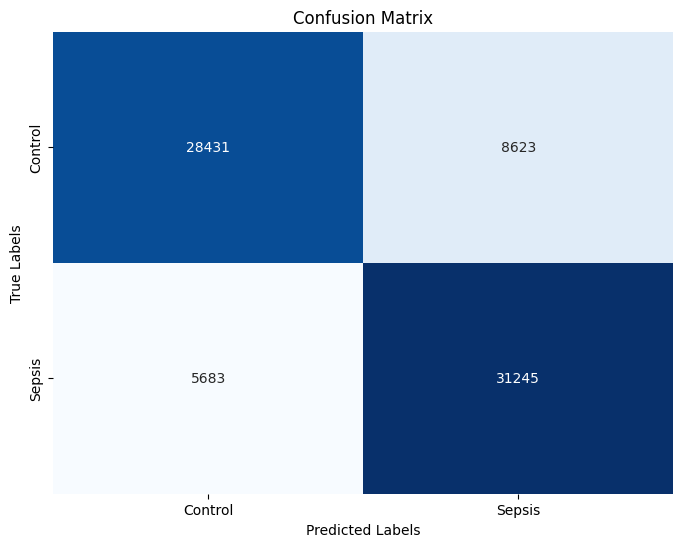

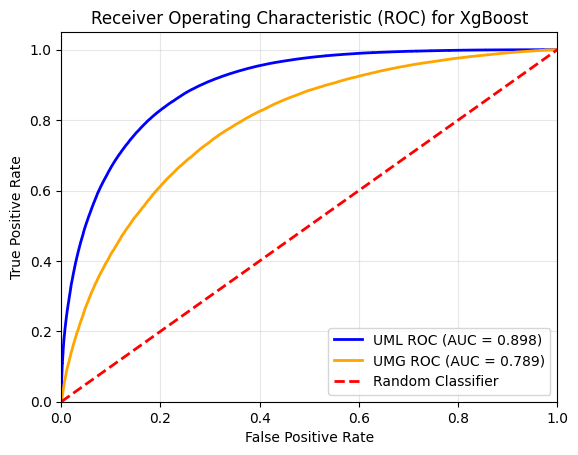

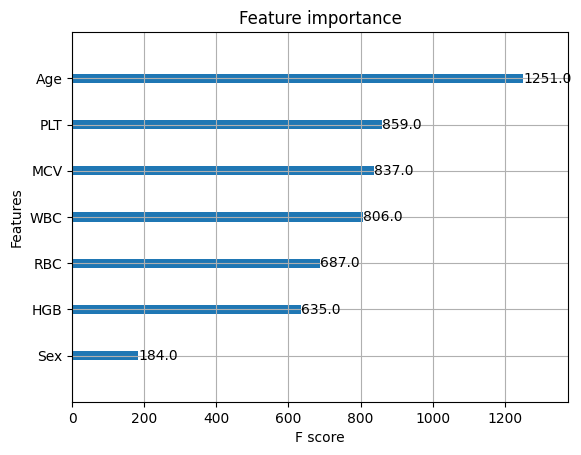

In [ ]:
#XGBOOST EVALUATION


model = xgb.XGBClassifier()

metrics_train, metrics_val = train_eval_model(model=model, df_train=df_uml, df_val=df_umg)

print("Training Metrics:")
print(f"Accuracy:     {metrics_train['accuracy']:.4f}")
print(f"Recall:       {metrics_train['recall']:.4f}")
print(f"F1 Score:     {metrics_train['f1_score']:.4f}")
print(f"ROC AUC:      {metrics_train['roc_auc']:.4f}")

print("Validation Metrics:")
print(f"Accuracy:     {metrics_val['accuracy']:.4f}")
print(f"Recall:       {metrics_val['recall']:.4f}")
print(f"F1 Score:     {metrics_val['f1_score']:.4f}")
print(f"ROC AUC:      {metrics_val['roc_auc']:.4f}")

visualizations.plot_confusion_matrix(metrics_train)
visualizations.plot_roc_curves(df1=df_uml, df2=df_umg, model_metrics=metrics_train)
visualizations.plot_feature_importance(metrics_train)